In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Segmentation
from astropy.io import fits
from photutils.segmentation import SourceFinder, make_2dgaussian_kernel, SourceCatalog
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve

# grizli
from grizli.model import GrismFLT

In [2]:
# Process direct image and produce segmentation map

# Open image
direct_file = "rot_mod_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
seg_file = "seg.fits"
direct_fits = fits.open(direct_file)
data, header = (direct_fits[1].data, direct_fits[1].header)


# Subtract background
bkg_estimator = MedianBackground()
bkg = Background2D(data, (511,511), filter_size=(3,3), bkg_estimator=bkg_estimator)
data -= bkg.background

# Convolve image
kernel = make_2dgaussian_kernel(3.0, 5)
convolved_data = convolve(data, kernel)

# Instantiate the SourceFinder and set threshold
finder = SourceFinder(npixels=7, nlevels=32, contrast=0.001)
threshold = 2 * bkg.background_rms

seg_map = finder(convolved_data, threshold)

# Save seg_map as fits
fits.writeto(seg_file, seg_map, header=header,overwrite=True)

Deblending:   0%|          | 0/6281 [00:00<?, ?it/s]

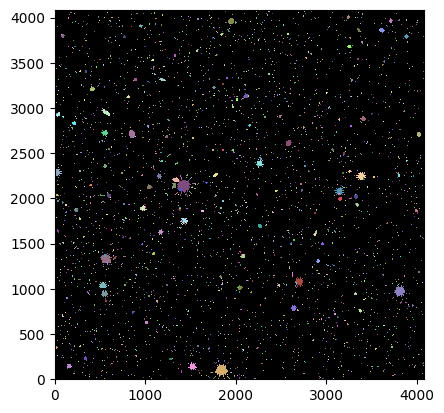

In [3]:
plt.imshow(seg_map, cmap=seg_map.cmap, interpolation='nearest', origin='lower')

In [4]:
# Create Catalog
cat = SourceCatalog(data, seg_map, convolved_data=convolved_data)
cat.add_extra_property('id', cat.label, overwrite=True)
cat.add_extra_property('mag', cat.segment_flux, overwrite=True)
cat.add_extra_property('x_flt', cat.xcentroid, overwrite=True)
cat.add_extra_property('y_flt', cat.ycentroid, overwrite=True)

columns = ['id', 'x_flt', 'y_flt', 'mag', 'area', 'semimajor_sigma', 'semiminor_sigma',
           'orientation', 'eccentricity', 'min_value', 'max_value']
tbl = cat.to_table(columns)

In [5]:
# Mask a box on the sky
mask = (abs(tbl["x_flt"] - 2370) < 100) & (abs(tbl["y_flt"] - 3350) < 100)

In [6]:
(tbl["id"] == 1).sum()

1

In [7]:
# Instantiate the GrismFLT object, give it the catalog
sim_fov0 = GrismFLT(direct_file=direct_file, seg_file=seg_file)
sim_fov0.catalog = tbl



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
rot_mod_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 576 pixels
rot_mod_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [8]:
sim_fov0.compute_full_model(ids=tbl['id'][mask], mags=tbl['mag'][mask], mag_limit=28)

(52, 0, -0.0, 52, 0, -0.0, 0, -99.0)
Failing at step 3
ID 5679 not found in segmentation image
(52, 0, -0.0, 52, 0, -0.0, 0, -99.0)
Failing at step 3
ID 5698 not found in segmentation image
(52, 0, -0.0, 52, 0, -0.0, 0, -99.0)
Failing at step 3
ID 5700 not found in segmentation image
(52, 0, -0.0, 52, 0, -0.0, 0, -99.0)
Failing at step 3
ID 5710 not found in segmentation image
(52, 0, -0.0, 52, 0, -0.0, 0, -99.0)
Failing at step 3
ID 5737 not found in segmentation image
(52, 0, -0.0, 52, 0, -0.0, 0, -99.0)
Failing at step 3
ID 5781 not found in segmentation image
(52, 0, -0.0, 52, 0, -0.0, 0, -99.0)
Failing at step 3
ID 5785 not found in segmentation image
(52, 0, -0.0, 52, 0, -0.0, 0, -99.0)
Failing at step 3
ID 5801 not found in segmentation image
(52, 0, -0.0, 52, 0, -0.0, 0, -99.0)
Failing at step 3
ID 5802 not found in segmentation image
(52, 0, -0.0, 52, 0, -0.0, 0, -99.0)
Failing at step 3
ID 5805 not found in segmentation image
(52, 0, -0.0, 52, 0, -0.0, 0, -99.0)
Failing at st

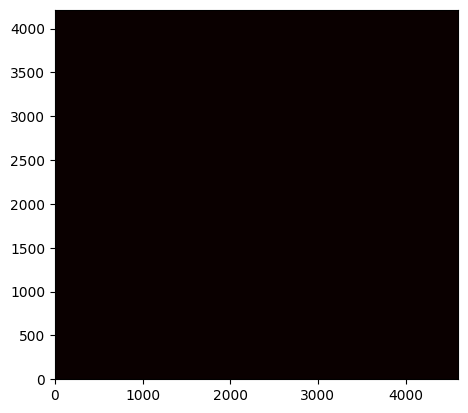

In [9]:
fig, ax = plt.subplots()
ax.imshow(sim_fov0.model, interpolation='Nearest', 
           origin='lower', vmin=0.4, vmax=5., cmap='hot')

In [10]:
np.max(sim_fov0.model)

0.0